In [1]:
# 한국어 토크나이저 다운로드를 위한 코드
!pip install -U pip
!pip install -q konlpy

# 군집화를 위한 sentence-transformer 를 위해 다운로드 
!pip install -U sentence-transformers
# 한국어 토크나이저중 mecab 사용을 위해 다운로드 
!pip install -q python-mecab-ko

# sparse-topn을 사용하기 위한 코드임 
!pip install -q /kaggle/input/sparse-dot-topn-033/sparse_dot_topn-0.3.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.8 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.9 MB/s eta 0:00:00


In [12]:
# Pretrained Tokenizer mecab 은 세팅 
from mecab import MeCab

mecab = MeCab()

def tokenizer_mecab(text):
    return mecab.morphs(text)

In [13]:
import random
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

real_test_df = pd.read_csv('/kaggle/input/llm-detection-result/ghost_bursting.csv')
display(real_test_df.head())

print('실제 논술 데이터 : ',len(real_test_df))

,생성 Text,label,generated
0,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,1,0.784599
1,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,1,0.656423
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",1,0.625514
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1,0.648654
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1,0.886805


실제 논술 데이터 :  501


In [14]:
import argparse
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn


class TextMatcher:
    def __init__(self, ground_truth, col, topk=5, lower_bound=-1):
        self.ground_truth = ground_truth
        self.vec = TfidfVectorizer(ngram_range=(1, 2), analyzer="word",tokenizer=tokenizer_mecab,
                                   use_idf=False, min_df=2, binary=True)
        self.topk = topk
        self.lower_bound = lower_bound
        self.col = col
        
    def get_matches_df(self, sparse_matrix, texts):
        non_zeros = sparse_matrix.nonzero()

        text_indices = non_zeros[0]
        gt_indices = non_zeros[1]

        left_side = np.empty(gt_indices.size, dtype=object)
        right_side = np.empty(gt_indices.size, dtype=object)
        match_score = np.zeros(gt_indices.size)

        for index in range(gt_indices.size):
            left_side[index] = texts.values[text_indices[index]]
            right_side[index] = self.ground_truth[self.col].values[gt_indices[index]]
            match_score[index] = sparse_matrix.data[index]

        res_df = pd.DataFrame({self.col: left_side,
                               'Ground Truth': right_side,
                               'match_score': match_score})

        res_df = pd.DataFrame(texts).merge(res_df, on=self.col, how="left")
        return res_df


    def match(self, texts_to_match, n_threads=16):
        print(f"Matching {texts_to_match.shape[0]} texts to {self.ground_truth.shape[0]} texts...")
        
        X = self.vec.fit_transform(texts_to_match[self.col])
        X_gt = self.vec.transform(self.ground_truth[self.col])
        
        sparse_sim = awesome_cossim_topn(X, X_gt.T, self.topk, self.lower_bound, use_threads=True, n_jobs=n_threads)
        
        return self.get_matches_df(sparse_sim, texts_to_match[self.col])

In [15]:
#---------------------------------------------------------------------------------------------------------#

# E: Ahmet's Approach
# !python run_ahmet_approach.py \
# --score_path ./outputs/m0.parquet \
# --save_dir "./outputs" \
# --model_id "m5"

#---------------------------------------------------------------------------------------------------------#

# 우리가 볼 df -> test_df
df = real_test_df.copy()
df['prompt_id'] = 0
df['id'] = [ i for i in range(len(df))]
all_prompts = df["prompt_id"].unique()
df = df.rename(columns={'생성 Text': 'text'})
 
# HUMAN_TH = 0.1
# LLM_TH = 0.99

HUMAN_TH = 0.2
LLM_TH = 0.8

MIN_N = min(64, len(df))

df_list = []

for pid in all_prompts:
    
    # prompt id 현재 pid 인 값만 가져오기
    cdf = df[df['prompt_id']==pid].copy() 
    
    # 위에서부터 generated 값 낮은것부터 정렬해서 가져옴
    cdf = cdf.sort_values(by='generated').reset_index(drop=True)
    
    # 0.1 보다 낮거나 같으면 인간이 생성한거임 
    cdf["likely_student"] = cdf["generated"].apply(lambda x: x<=HUMAN_TH)
    
    # 0.99보다 같거나 크면 llm 이 생성한 거임 
    cdf["likely_llm"] = cdf["generated"].apply(lambda x: x>=LLM_TH)
    
    # likely_student 의 전체합이 Min_N 보다 작으면 MIN_N 행까지 likely_Student 값을 True 로 만든다.
    if cdf["likely_student"].sum() < MIN_N:
        cdf.loc[:MIN_N, "likely_student"] = True
    
    # likely llm 전체 합 값이 MIN_M보다 작으면 뒤에서부터 MIN_N까지의 likley llm 값을 True로 만든다. 
    if cdf["likely_llm"].sum() < MIN_N:
        cdf.loc[cdf.shape[0] - MIN_N:, "likely_llm"] = True
        
    display(cdf.head())
    display(cdf.tail())
    print("=="*40)
    df_list.append(cdf)

# 다합치고 generated 확률값없애는 거임 
df = pd.concat(df_list).reset_index(drop=True)
df = df.drop(columns=['generated'])

,text,label,generated,prompt_id,id,likely_student,likely_llm
0,(가)의 ㉠은 제2차 세계 대전 중에 자행된 독일군의 유대인 학살로부터 인간 존엄...,0,0.050741,0,336,True,False
1,"\n인간은 자신이 지각한 세계를 바탕으로 세상을 바라본다. 어쩌면, 대부분의 사람들...",0,0.054420,0,23,True,False
2,성적 기준의 방식을 선택하겠다. 장학금 지급을 학생들에 대한 투자로 볼 때 이 방식...,0,0.056326,0,404,True,False
3,(2) ( ) ‘ ’ . 제시문 마 의 붉은 여왕의 나라 는 두 가지 의미를 가지고...,0,0.076854,0,286,True,False
4,\n무지의 무지란 스스로가 모르고 있다는 사실조차 모르는 상태를 의미한다. 한번도 ...,0,0.089241,0,24,True,False


,text,label,generated,prompt_id,id,likely_student,likely_llm
496,\n제시문 [가]는 저출산과 고령화가 민간소비에 미치는 영향을 다루고 있습니다. 이...,1,0.947307,0,121,False,True
497,제시문 [가]에서는 인터넷을 통한 정보의 선택적 접근이 집단 극화와 사회 통합의 저...,1,0.948571,0,413,False,True
498,"제시문 [가]에서 제기한 문제를 극복하기 위해서는 네티즌들이 다양한 의견을 접하고,...",1,0.978624,0,441,False,True
499,제시문 [가]와 [다]는 각각 여유와 예술교육의 중요성을 다루며 지속가능성의 관점에...,1,0.980230,0,214,False,True
500,정부의 경제 개입이 국가 경제에 미치는 영향을 평가하기 위해서는 그 장단점을 고려해...,1,0.989701,0,72,False,True


In [16]:
#---------------------------------------------------------------------------------------------------------#
# MATCHING
#---------------------------------------------------------------------------------------------------------#

# 최소 64 개의 코사인 유사도를 구할거임 
TOPK = min(64, len(df))


# 인자로 score 배열 가져옴
def agg_fn(scores, margin=0.5):
    
    # 스코어 배열중 최대값 가져옴
    max_score = max(scores)
    
    #  margin 이 0.5 일시 최대값의 절반값이 된다. -> 이를 기준치라고 하자
    th = (1.0 - margin) * max_score
    
    # 기준치보다 큰수만 남긴다 이를 kept_scores 라고 한다. 
    kept_scores = [s for s in scores if s >= th]
    
    # 남겨진 수들의 평균값을 ret 라고 한다. 
    ret = np.mean(kept_scores)
    return ret

def get_match_score(df, gt_filter_col):
    # df[df[gt_filter_col]] 랑 df 는 명백히 다른거임 
    # df 는 전체데이터 즉, prompt_id 기준으로 걸러진거고 
    # df[df[gt_filter_col]] 은 llm,student 들이 잘 해결한거임 
    tm = TextMatcher(df[df[gt_filter_col]].reset_index(drop=True), "text", topk=TOPK)
    
    res_df = tm.match(df, n_threads=4)
    
    # match_score 에서 살짝 변형 시켜주고 text 기준으로 옆으로 이어붙임 
    df = res_df.groupby("text")["match_score"].agg(agg_fn).reset_index().merge(df, on="text")
    return df


sub_dfs = [get_match_score(df[df["prompt_id"] == pid], "likely_student").reset_index(drop=True)[["id", "match_score"]]
           for pid in all_prompts] # TODO: may cause exception?
sub_df = pd.concat(sub_dfs).rename(columns={"match_score": "match_score_student"})


sub_dfs = [get_match_score(df[df["prompt_id"] == pid], "likely_llm").reset_index(drop=True)[["id", "match_score"]]
           for pid in all_prompts]
sub_df2 = pd.concat(sub_dfs).rename(columns={"match_score": "match_score_llm"})

sub_df = sub_df.merge(sub_df2, on="id")

SMOOTH = 0.15

sub_df["new generated"] = -sub_df["match_score_student"] / (sub_df["match_score_llm"] + SMOOTH)
sub_df.head()
# sub_df = sub_df[["id", "generated"]].copy()

# sub_df.to_excel('output_1.xlsx',index=False)

Matching 501 texts to 65 texts...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Matching 501 texts to 150 texts...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,id,match_score_student,match_score_llm,new generated
0,6,0.186722,0.231951,-0.488863
1,11,1.000000,0.188869,-2.950990
2,28,1.000000,0.191927,-2.924601
3,16,0.197640,0.204583,-0.557386
4,21,0.190341,0.195849,-0.550358


In [17]:
display(sub_df.head())
display(real_test_df.head())

,id,match_score_student,match_score_llm,new generated
0,6,0.186722,0.231951,-0.488863
1,11,1.000000,0.188869,-2.950990
2,28,1.000000,0.191927,-2.924601
3,16,0.197640,0.204583,-0.557386
4,21,0.190341,0.195849,-0.550358


,생성 Text,label,generated
0,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,1,0.784599
1,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,1,0.656423
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",1,0.625514
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1,0.648654
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1,0.886805


In [18]:
# 예시: id 열을 기준으로 두 데이터프레임을 결합합니다.
merged_df = pd.merge(sub_df, df, on="id", how="inner")
display(merged_df.head(20))

,id,match_score_student,match_score_llm,new generated,text,label,prompt_id,likely_student,likely_llm
0,6,0.186722,0.231951,-0.488863,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0,False,False
1,11,1.000000,0.188869,-2.950990,"\n(가) 제시문은 생명 복제 기술의 문제점에 대하여 논하고 있다. 인간의 고유성,...",0,0,True,False
2,28,1.000000,0.191927,-2.924601,\n(가)를 통해 '돈'은 물물교환에 있어 상품의 가치를 반영하는 매개 수단임을 알...,0,0,True,False
3,16,0.197640,0.204583,-0.557386,\n(가)에서 이름을 부르는 행위는 존재에 의미를 부여하는 행위를 가리키고 있다. ...,0,0,False,False
4,21,0.190341,0.195849,-0.550358,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0,False,False
5,280,0.185002,1.000000,-0.160871,"\n(가)와 (나)에서 나타난 문화의 형성 원리와 성격은 개인의 사회적, 경제적 환...",1,0,False,True
6,18,0.186091,0.223989,-0.497584,\n(가)의 주장은 경제적 불평등을 해소하기 위해 부의 재분배가 필요하다는 것입니다...,1,0,False,False
7,44,0.202148,0.209263,-0.562675,\n(가)의 필자는 인간의 문해력은 생득적인 것이 아닌 후천적 성취라고 주장하며 현...,0,0,False,False
8,35,1.000000,0.194904,-2.899354,\n(가)의 필자는 인간의 유아론적 경향을 서술하며 그동안 과학자들이 '감정적 자아...,0,0,True,False
9,102,0.174964,1.000000,-0.152142,"\n[가]에서 주제를 나타내는 단어는 ""역할 바꾸기""입니다. 이 단어를 사용하여 [...",1,0,False,True


In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

min_val = min(merged_df['new generated'])
max_val = max(merged_df['new generated'])

# Min-Max 스케일링 함수 정의
def min_max_scaling(x):
    return (x - min_val) / (max_val - min_val)

merged_df['real_generated']= merged_df['new generated'].apply(min_max_scaling)
# 변환된 결과 확인
display(merged_df.head(20))

,id,match_score_student,match_score_llm,new generated,text,label,prompt_id,likely_student,likely_llm,real_generated
0,6,0.186722,0.231951,-0.488863,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0,False,False,0.882631
1,11,1.000000,0.188869,-2.950990,"\n(가) 제시문은 생명 복제 기술의 문제점에 대하여 논하고 있다. 인간의 고유성,...",0,0,True,False,0.125728
2,28,1.000000,0.191927,-2.924601,\n(가)를 통해 '돈'은 물물교환에 있어 상품의 가치를 반영하는 매개 수단임을 알...,0,0,True,False,0.133840
3,16,0.197640,0.204583,-0.557386,\n(가)에서 이름을 부르는 행위는 존재에 의미를 부여하는 행위를 가리키고 있다. ...,0,0,False,False,0.861565
4,21,0.190341,0.195849,-0.550358,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0,False,False,0.863726
5,280,0.185002,1.000000,-0.160871,"\n(가)와 (나)에서 나타난 문화의 형성 원리와 성격은 개인의 사회적, 경제적 환...",1,0,False,True,0.983461
6,18,0.186091,0.223989,-0.497584,\n(가)의 주장은 경제적 불평등을 해소하기 위해 부의 재분배가 필요하다는 것입니다...,1,0,False,False,0.879950
7,44,0.202148,0.209263,-0.562675,\n(가)의 필자는 인간의 문해력은 생득적인 것이 아닌 후천적 성취라고 주장하며 현...,0,0,False,False,0.859939
8,35,1.000000,0.194904,-2.899354,\n(가)의 필자는 인간의 유아론적 경향을 서술하며 그동안 과학자들이 '감정적 자아...,0,0,True,False,0.141602
9,102,0.174964,1.000000,-0.152142,"\n[가]에서 주제를 나타내는 단어는 ""역할 바꾸기""입니다. 이 단어를 사용하여 [...",1,0,False,True,0.986145


ROC-AUC 면적: 0.9487407407407408


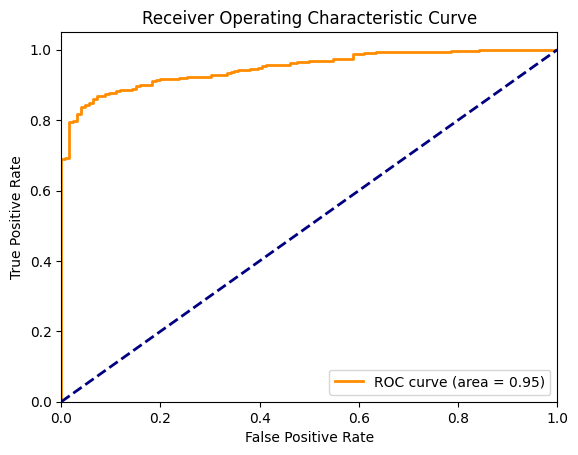

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 라벨
y_true = merged_df['label'].values

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_true, merged_df['real_generated'])
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# ROC-AUC 면적 출력
print("ROC-AUC 면적:", roc_auc)

plt.show()

In [21]:
from sklearn.metrics import f1_score

# F1 스코어 계산
y_pred = [1 if score > 0.5 else 0 for score in merged_df['real_generated']]  # fixed_results는 모델 예측 결과로 가정
f1 = f1_score(y_true,  y_pred)

# F1 스코어 출력
print("F1 Score:", f1)

F1 Score: 0.9023485784919654
